In [1]:
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from metric import apk, mapk
from utils import plot_images

sns.set_theme()

In [13]:
dataset = '100'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")
merged = pd.read_pickle(f"output/merged_{dataset}.pkl")
valid_all = pd.read_pickle(f"output/valid_all_{dataset}.pkl")

In [14]:
num_week = 16
num_user_transactions = transactions.query('1 <= week <= 1 + @num_week').groupby('user').size().reset_index(name='num_transactions')
user_purchased_items = transactions.query('1 <= week <= 1 + @num_week').groupby('user')['item'].agg(set).reset_index(name='prev_purchased_items')

In [15]:
merged['apk'] = merged.apply(lambda x: apk(x['gt'], x['item']), axis=1)
merged = merged.merge(num_user_transactions, on='user', how='left').fillna(0)
merged = merged.merge(user_purchased_items, on='user', how='left')
merged['prev_purchased_items'] = merged['prev_purchased_items'].apply(lambda x: x if type(x) == set else set())

merged['num_repurchase_in_gt'] = merged.apply(lambda x: len(set(x['gt']).intersection(x['prev_purchased_items'])), axis=1)
merged['num_repurchase_in_pred'] = merged.apply(lambda x: len(set(x['item']).intersection(x['prev_purchased_items'])), axis=1)

In [16]:
merged[['num_transactions']].describe()

,num_transactions
count,68984.000000
mean,12.316030
std,18.033225
min,0.000000
25%,1.000000
50%,7.000000
75%,16.000000
max,425.000000


<AxesSubplot:xlabel='num_repurchase_in_gt', ylabel='apk'>

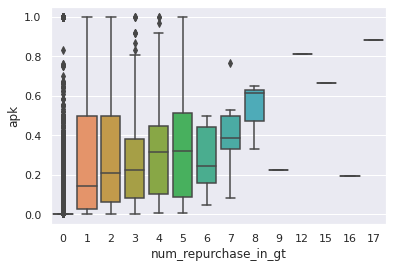

In [17]:
sns.boxplot(data=merged, x='num_repurchase_in_gt', y='apk')

array([[<AxesSubplot:title={'center':'num_repurchase_in_gt'}>]],
      dtype=object)

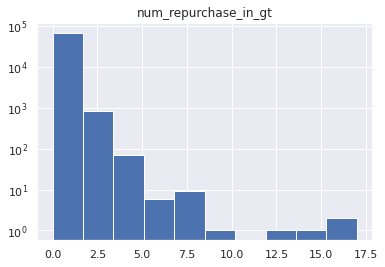

In [18]:
merged[['num_repurchase_in_gt']].hist(log=True)

<AxesSubplot:xlabel='num_repurchase_in_pred', ylabel='apk'>

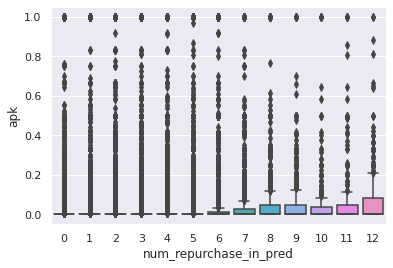

In [19]:
sns.boxplot(data=merged, x='num_repurchase_in_pred', y='apk')

array([[<AxesSubplot:title={'center':'num_repurchase_in_pred'}>]],
      dtype=object)

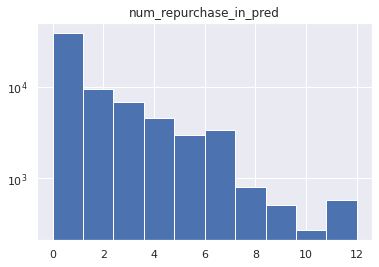

In [20]:
merged[['num_repurchase_in_pred']].hist(log=True)

<AxesSubplot:xlabel='num_transactions', ylabel='apk'>

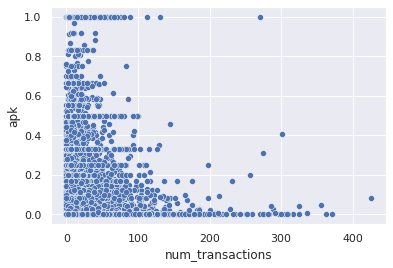

In [10]:
sns.scatterplot(data=merged, x='num_transactions', y='apk')

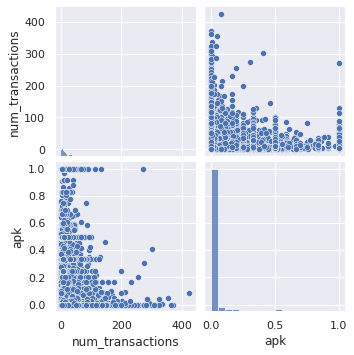

In [11]:
sns.pairplot(data=merged[['num_transactions', 'apk']])

In [22]:
gt = transactions.query('week == 0')[['user', 'item']]
gt['label'] = 1

valid_all = valid_all.merge(gt, on=['user', 'item'])
valid_all['label'] = valid_all['label'].fillna(0)

In [27]:
valid_all.groupby('strategy')[['label']].sum()

,label
strategy,
cooc,7640
pop,7480
pop_segment_wise,5409
repurchase,17880
same_product_code,11184
